In [12]:
pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Step 2: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy import stats

In [14]:
# Step 2: Define functions for data loading, preprocessing, and analysis

def load_and_preprocess_data(file_path, chunksize=100000):
    """
    Load and preprocess data from an Excel file in chunks.
    
    Args:
    file_path (str): Path to the Excel file
    chunksize (int): Number of rows to process at a time
    
    Returns:
    pd.DataFrame: Preprocessed data
    """
    # Read the entire Excel file into a DataFrame
    df = pd.read_excel(file_path)
    processed_chunks = []
    
    # Process the DataFrame in chunks
    for start in range(0, len(df), chunksize):
        chunk = df.iloc[start:start + chunksize].copy()
        
        # Handle missing values
        chunk['Description'] = chunk['Description'].fillna('Unknown')
        chunk['CustomerID'] = chunk['CustomerID'].fillna(-1)
        
        # Remove duplicates
        chunk.drop_duplicates(inplace=True)
        
        # Handle outliers using IQR method
        for col in ['Quantity', 'UnitPrice']:
            Q1 = chunk[col].quantile(0.25)
            Q3 = chunk[col].quantile(0.75)
            IQR = Q3 - Q1
            chunk = chunk[(chunk[col] >= Q1 - 1.5*IQR) & (chunk[col] <= Q3 + 1.5*IQR)]
        
        # Feature engineering
        chunk['TotalPrice'] = chunk['Quantity'] * chunk['UnitPrice']
        chunk['InvoiceDate'] = pd.to_datetime(chunk['InvoiceDate'])
        
        processed_chunks.append(chunk)
    
    return pd.concat(processed_chunks, ignore_index=True)

In [15]:
# Step 2: Enhanced RFM analysis
def enhanced_rfm_analysis(df):
    # Create the RFM dataframe by grouping by CustomerID
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (pd.to_datetime('today') - x.max()).days,  # Recency
        'InvoiceNo': 'count',  # Frequency
        'TotalPrice': 'sum'  # Monetary
    }).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})
    
    # Log transformation to normalize the RFM values
    rfm['Recency_Log'] = np.log1p(rfm['Recency'])
    rfm['Frequency_Log'] = np.log1p(rfm['Frequency'])
    rfm['Monetary_Log'] = np.log1p(rfm['Monetary'])
    
    # Drop rows with NaN values in the log-transformed columns
    rfm.dropna(subset=['Recency_Log', 'Frequency_Log', 'Monetary_Log'], inplace=True)
    
    return rfm

In [16]:
# Step 3: Improved clustering with DBSCAN and KMeans (with NaN handling)
def improved_clustering(rfm):
    # Select relevant features for clustering
    X = rfm[['Recency_Log', 'Frequency_Log', 'Monetary_Log']]
    
    # Check for NaN values and remove rows containing NaNs
    if X.isnull().any().any():
        print("NaN values detected in the dataset. Removing rows with NaN values.")
        X = X.dropna()
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    rfm['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)
    
    # K-means Clustering with optimal K
    silhouette_scores = []
    K = range(2, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    
    optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    rfm['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
    
    return rfm, optimal_k

In [17]:
# Step 5: Advanced visualization using PCA
def advanced_visualization(rfm):
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(rfm[['Recency_Log', 'Frequency_Log', 'Monetary_Log']])
    
    # KMeans clusters
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=rfm['KMeans_Cluster'], cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Customer Segments (K-means)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    
    # DBSCAN clusters
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=rfm['DBSCAN_Cluster'], cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Customer Segments (DBSCAN)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

In [18]:
# Step 6: Segment profiling
def segment_profiling(rfm):
    for cluster in rfm['KMeans_Cluster'].unique():
        segment = rfm[rfm['KMeans_Cluster'] == cluster]
        print(f"\nCluster {cluster} Profile:")
        print(segment[['Recency', 'Frequency', 'Monetary']].describe())
        print("\nTop 5 customers in this segment:")
        print(segment.nlargest(5, 'Monetary')[['Recency', 'Frequency', 'Monetary']])

In [19]:
# Step 7: Calculate customer lifetime value (CLV)
def calculate_clv(rfm):
    # Simple CLV calculation (you may want to use more sophisticated methods)
    rfm['CLV'] = rfm['Frequency'] * rfm['Monetary'] / rfm['Recency']
    return rfm

In [20]:

# Step 8: Cohort analysis
def cohort_analysis(df):
    df['CohortDate'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
    df['CohortIndex'] = (df['InvoiceDate'].dt.to_period('M') - df['CohortDate']).apply(lambda x: x.n)
    
    cohort_data = df.groupby(['CohortDate', 'CohortIndex'])['CustomerID'].nunique().reset_index()
    cohort_data = cohort_data.pivot(index='CohortDate', columns='CohortIndex', values='CustomerID')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cohort_data.T, cmap="YlGnBu")
    plt.title('Customer Cohort Analysis')
    plt.xlabel('Cohort Date')
    plt.ylabel('Cohort Index')
    plt.show()

In [21]:
# Step 9: Save results to CSV in chunks
def save_results_efficiently(rfm, filename_prefix='customer_segments', chunksize=10000):
    """
    Save results to CSV files in chunks.
    
    Args:
    rfm (pd.DataFrame): RFM dataframe with cluster labels
    filename_prefix (str): Prefix for output CSV files
    chunksize (int): Number of rows to save in each chunk
    """
    for i, chunk in enumerate(np.array_split(rfm, len(rfm) // chunksize + 1)):
        chunk_df = pd.DataFrame(chunk, columns=rfm.columns)
        chunk_df.to_csv(f'{filename_prefix}_{i}.csv', index=True)
        print(f"Saved chunk {i}")

c:\Users\Tobi\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


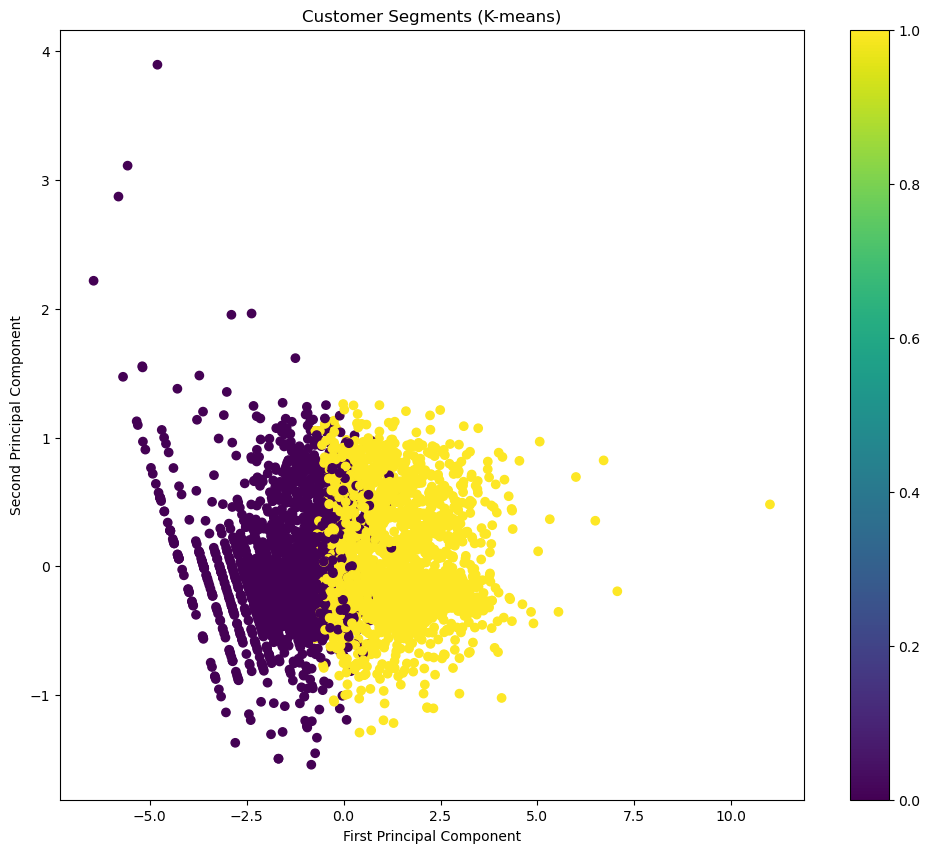

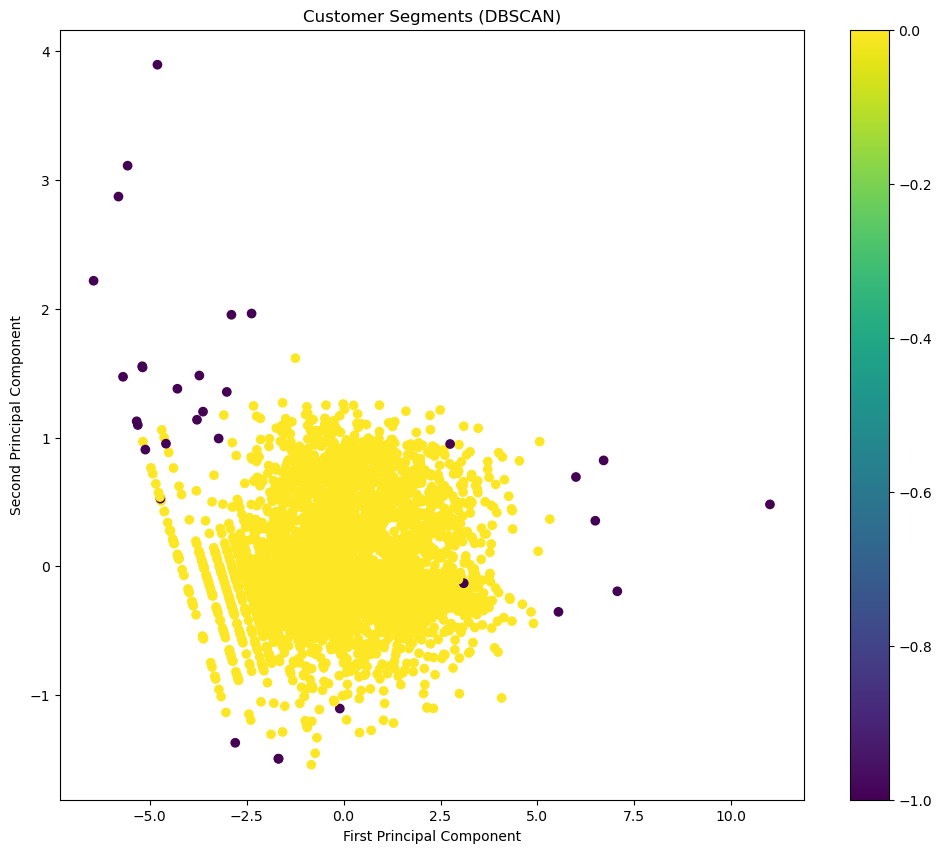


Cluster 1 Profile:
           Recency      Frequency       Monetary
count  2267.000000    2267.000000    2267.000000
mean   4707.194971     188.218350    2059.859824
std      42.494960    2492.523379   18351.507887
min    4669.000000      14.000000     133.250000
25%    4678.000000      48.000000     602.810000
50%    4693.000000      81.000000    1020.300000
75%    4722.000000     144.500000    1946.160000
max    4984.000000  118120.000000  865571.280000

Top 5 customers in this segment:
            Recency  Frequency   Monetary
CustomerID                               
-1.0           4670     118120  865571.28
 14911.0       4670       4622   83542.62
 14096.0       4673       4588   37939.19
 17841.0       4670       7453   31848.05
 13089.0       4673       1423   31626.76

Cluster 0 Profile:
           Recency    Frequency     Monetary
count  1924.000000  1924.000000  1924.000000
mean   4823.077963    17.487526   228.072038
std     110.141474    15.253325   165.740756
min    4670

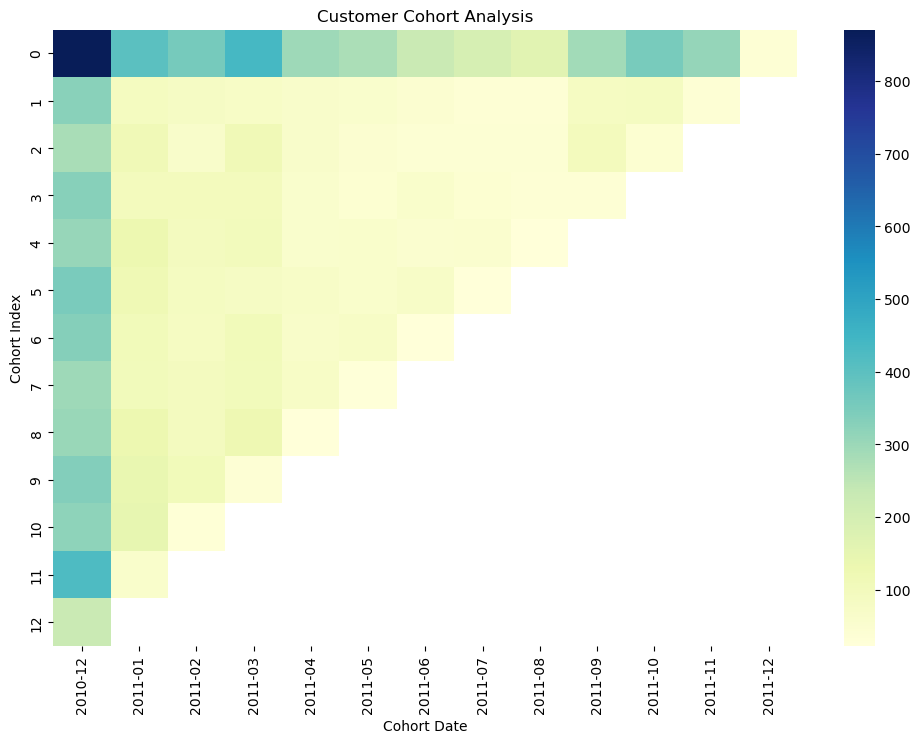

Optimal number of clusters: 2

Top 10 Customers by CLV:
            Recency  Frequency   Monetary           CLV  KMeans_Cluster
CustomerID                                                             
-1.0           4670     118120  865571.28  2.189321e+07               1
 14911.0       4670       4622   83542.62  8.268394e+04               1
 17841.0       4670       7453   31848.05  5.082731e+04               1
 14096.0       4673       4588   37939.19  3.724909e+04               1
 12748.0       4669       4121   20938.31  1.848078e+04               1
 13089.0       4673       1423   31626.76  9.630832e+03               1
 15311.0       4669       2033   16282.59  7.089849e+03               1
 14606.0       4670       2605    8865.82  4.945495e+03               1
 15039.0       4679       1378   15638.83  4.605751e+03               1
 14298.0       4677        849   21246.01  3.856716e+03               1


In [22]:
# Main execution
if __name__ == "__main__":
    # Step 1: Load and preprocess the data
    df = load_and_preprocess_data(r"C:\Users\Tobi\Customer Segmentation Project\Online Retail.xlsx")
    
    # Step 2: Perform RFM analysis
    rfm = enhanced_rfm_analysis(df)
    
    # Step 3: Improved clustering
    rfm, optimal_k = improved_clustering(rfm)
    
    # Step 4: Visualize the clusters
    advanced_visualization(rfm)
    
    # Step 5: Segment profiling
    segment_profiling(rfm)
    
    # Step 6: Calculate CLV
    rfm = calculate_clv(rfm)
    
    # Step 7: Perform cohort analysis
    cohort_analysis(df)
    
    # Output results
    print(f"Optimal number of clusters: {optimal_k}")
    print("\nTop 10 Customers by CLV:")
    print(rfm.nlargest(10, 'CLV')[['Recency', 'Frequency', 'Monetary', 'CLV', 'KMeans_Cluster']])
